# <center>NCAAM match predictions

## Imports

In [22]:
import os
import re
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

## Import data

In [23]:
path_datasets = 'data/MDataFiles_Stage1/'

df_regular_compact = pd.read_csv(path_datasets + 'MRegularSeasonCompactResults.csv')
df_regular_detailed = pd.read_csv(path_datasets + 'MRegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(path_datasets + 'MTeams.csv')
df_seeds = pd.read_csv(path_datasets + 'MNCAATourneySeeds.csv')
coaches = pd.read_csv(path_datasets + 'MTeamCoaches.csv')
df_tourney_compact = pd.read_csv(path_datasets + 'MNCAATourneyCompactResults.csv')
df_tourney_detailed = pd.read_csv(path_datasets + 'MNCAATourneyDetailedResults.csv')
df_seasons = pd.read_csv(path_datasets + 'MSeasons.csv')

In [24]:
df_regular_compact.describe()

Season         DayNum        WTeamID         WScore  \
count  161552.000000  161552.000000  161552.000000  161552.000000   
mean     2003.228731      74.665359    1286.919004      76.795125   
std        10.058660      33.670352     104.521630      12.066260   
min      1985.000000       0.000000    1101.000000      34.000000   
25%      1995.000000      47.000000    1198.000000      69.000000   
50%      2004.000000      77.000000    1284.000000      76.000000   
75%      2012.000000     103.000000    1380.000000      84.000000   
max      2019.000000     132.000000    1466.000000     186.000000   

             LTeamID         LScore          NumOT  
count  161552.000000  161552.000000  161552.000000  
mean     1282.637498      64.692526       0.045137  
std       104.742961      11.349610       0.249751  
min      1101.000000      20.000000       0.000000  
25%      1191.000000      57.000000       0.000000  
50%      1280.000000      64.000000       0.000000  
75%      1375.000000      72.000000       0.000000  
max      1466.000000     150.000000       6.000000

### Check data sanity

In [25]:
print('Regular Season compact Results :\n', df_regular_compact.isnull().sum().T)
print("-"*10)

print('Regular Season detailed Results :\n', df_regular_detailed.isnull().sum().T)
print("-"*10)

print('Teamsts :\n', df_teams.isnull().sum().T)
print("-"*10)

print('Seeds :\n', df_seeds.isnull().sum().T)
print("-"*10)

print('Coaches :\n', coaches.isnull().sum().T)
print("-"*10)

print('Tourney compact Results :\n', df_tourney_compact.isnull().sum().T)
print("-"*10)

print('Tourney compact Results :\n', df_tourney_detailed .isnull().sum().T)
print("-"*10)

Regular Season compact Results :
 Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
dtype: int64
----------
Regular Season detailed Results :
 Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
WFGM       0
WFGA       0
WFGM3      0
WFGA3      0
WFTM       0
WFTA       0
WOR        0
WDR        0
WAst       0
WTO        0
WStl       0
WBlk       0
WPF        0
LFGM       0
LFGA       0
LFGM3      0
LFGA3      0
LFTM       0
LFTA       0
LOR        0
LDR        0
LAst       0
LTO        0
LStl       0
LBlk       0
LPF        0
dtype: int64
----------
Teamsts :
 TeamID           0
TeamName         0
FirstD1Season    0
LastD1Season     0
dtype: int64
----------
Seeds :
 Season    0
Seed      0
TeamID    0
dtype: int64
----------
Coaches :
 Season         0
TeamID         0
FirstDayNum    0
LastDayNum     0
CoachName      0
dtype: int64
----------
Tourney compact Results :
 Season    

### Concat match details in one dataframe

In [26]:
# add match type
df_regular_detailed["Type"] = "regular"
df_tourney_detailed["Type"] = "tourney"

# We join the data from the regular matchs and tourney matchs
df_match_detailed = pd.concat([df_regular_detailed, df_tourney_detailed])

# We create an idea for a match between two teams : team1_team2(team1 < team2)
df_match_detailed["Match"] = df_match_detailed \
                                .apply(lambda row: "_".join(map(str, sorted([row["WTeamID"], row["LTeamID"]]))), axis=1)

df_match_detailed["Team1"] = df_match_detailed["Match"].apply(lambda x: int(x.split("_")[0]))
df_match_detailed["Team2"] = df_match_detailed["Match"].apply(lambda x: int(x.split("_")[1]))

df_match_detailed["Label"] = df_match_detailed.apply(lambda row: 1 if row["WTeamID"] == row["Team1"] else 0, axis=1)

# WLoc to numeric type
df_match_detailed["WLoc"] = df_match_detailed["WLoc"].map({"H": 0, "A": 1, "N": 3})
# Type to numeric type
df_match_detailed["Type"] = df_match_detailed["Type"].map({"regular": 0, "tourney": 1})

## Create interesting metrics

Features initiales Luc:

* % de victoires
* % de victoires à domicile et à l'exterieur
* Nombre de points marqués et encaissés en moyenne
* Nombre d'interceptions et de rebonds
* % de réussites à 3pts
* Nombre de lancers francs tentés/marqués

Features à ajouter possiblement:

* L'équipe joue à domicile ?
* % de victoire contre une équipe de rang équivalent (à 1 ou deux seed près?)
* Nombre de fois que l'équipe à fait le championnat

Le travail se répartie entre les différentes personnes du groupe (je prend les trois dernières)

### Metrics Luc

#### Win rate

In [27]:
# %%time
### Creation of a Dataframe with the win rate for a given team at a given season 
# win rate = number of wins / number of match 
# win rate = nan if no match for this season and this team

#We copy the useful column to speed up the data extraction
df_match_detailed_utils = df_match_detailed[['Season', 'Team1', 'Team2','Label']].copy()

def get_win_rate(df, team):
    label_as_team1 = df.loc[(df['Team1']==team)]['Label']
    label_as_team2 = df.loc[(df['Team2']==team)]['Label']
    
    num_match = label_as_team1.size + label_as_team2.size
    # if team is team1, then it wins if label = 1
    # if team is team2, then it wins if label = 0
    num_wins = label_as_team1.loc[label_as_team1 == 1].size + label_as_team2.loc[label_as_team2 == 0].size

    #return num_wins/num_match
    if num_match == 0:
        return np.nan
    else :
        return num_wins/num_match

# We create the dataframe with Season, TeamID keys and win_rate
new_line = []
for season in df_seasons['Season'] :
#     print(season)
    df_season_temp = df_match_detailed_utils[df_match_detailed_utils['Season']==season]
    for team in df_teams['TeamID']:
        win_rate = get_win_rate(df_season_temp, team)
        new_line.append([season, team, win_rate])

df_win_rate = pd.DataFrame(new_line, columns = ['Season', 'TeamID','win_rate'])

#### Mean score

In [28]:
%%time
### Creation of a Dataframe with the mean scored points and conceded points per match per team per season#We copy the useful column to speed up the data extraction
df_match_detailed_utils = df_match_detailed[['Season', 'WTeamID', 'LTeamID', 'WScore', 'LScore']].copy()

def get_mean_points_eric(df, team):
    points_as_WTeam = df.loc[(df['WTeamID']== team)][['WScore', 'LScore']]
    points_as_LTeam = df.loc[(df['LTeamID']== team)][['WScore', 'LScore']]
    
    if ((points_as_WTeam.shape[0]==0) and (points_as_LTeam.shape[0]==0)):
        return (np.nan, np.nan)
        
    else :
        conceded_points = (points_as_WTeam["LScore"].sum()+points_as_LTeam["WScore"].sum())/(points_as_WTeam.shape[0] + points_as_LTeam.shape[0])
        scored_points = (points_as_WTeam["WScore"].sum() + points_as_LTeam["LScore"].sum())/(points_as_WTeam.shape[0] + points_as_LTeam.shape[0])    
        return (scored_points, conceded_points)


# We create the dataframe with Season and TeamID keys, scored_points and conceded_points
                
new_line_scored = []
new_line_conceded = []

for season in df_seasons['Season']:
    #print(season)
    df_season_temp = df_match_detailed_utils[df_match_detailed_utils["Season"]==season]
    for team in df_teams['TeamID']:
        mean_scored_points, mean_conceded_points = get_mean_points_eric(df_season_temp, team)
        new_line_scored.append([season,team,mean_scored_points])
        new_line_conceded.append([season, team, mean_conceded_points])
    
df_points_scored = pd.DataFrame(new_line_scored, columns = ['Season', 'TeamID', 'mean_scored_points'])
df_points_conceded = pd.DataFrame(new_line_conceded, columns = ['Season', 'TeamID', 'mean_conceded_points'])

CPU times: user 46.6 s, sys: 188 ms, total: 46.8 s
Wall time: 46.8 s


### Metrics Marc

In [29]:
def seed_to_int(seed):
    s_int = int(seed[1:3])
    return s_int

df_int_seeds = df_seeds.copy()
# on remplace la variable seed par un entier
df_int_seeds['seed'] = df_int_seeds.Seed.apply(seed_to_int)
df_int_seeds.drop(columns=["Seed"], axis=1, inplace=True)

### Nombre d'interceptions et de rebonds par match et par saison

Pour créer ces paramètres nous avons besoin des dataframes suivant :

Comptés commme une interception : blocks, steals

Comptés comme rebond : offensive_rebounds, defensive_rebounds

In [30]:
df_match_detailed.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Type', 'Match', 'Team1', 'Team2', 'Label'],
      dtype='object')

#### Nombre de rebond en moyenne par match de chaque équipe sur chaque saison

In [31]:
# studied_parameter = "DR"
# data = df_match_detailed[["Season", "WTeamID", "LTeamID", "WDR" , "LDR"]].values
# winners_rebound_count = np.zeros(data.shape[0])
# losers_rebound_count = np.zeros(data.shape[0])
# for i, match in enumerate(data):
#     season = match[0]
#     winner = match[1]
#     loser = match[2]
    
#     previous_seasons = data[data[:,0] < season]
#     winner_previous_wins = previous_seasons[previous_seasons[:,1] == winner]
#     winner_previous_loses = previous_seasons[previous_seasons[:,2] == winner]
#     loser_previous_wins = previous_seasons[previous_seasons[:,1] == loser]
#     loser_previous_loses = previous_seasons[previous_seasons[:,2] == loser]
    
#     winner_rebound_count = np.sum(winner_previous_wins) + np.sum(winner_previous_loses)
#     loser_rebound_count = np.sum(loser_previous_wins) + np.sum(winner_previous_loses)
    
#     winners_rebound_count[i] = winner_rebound_count
#     losers_rebound_count[i] = loser_rebound_count

In [32]:
df_tmp = df_match_detailed[["Season", "WTeamID", "LTeamID", "WDR" , "LDR", "WOR", 'LOR']]
df_rebound_count_metric = pd.DataFrame(columns=["Season", "TeamID", "rebound_count"])
for season in df_tmp.Season.unique():
    df_season = df_tmp.loc[df_tmp.Season == season]
    for team in df_teams.TeamID.unique():
        rebound_count_win = df_season[["WDR", "WOR"]].loc[df_season.WTeamID == team].mean().sum()
        rebound_count_lose = df_season[["LDR", "LOR"]].loc[df_season.LTeamID == team].mean().sum()
        new_line = pd.DataFrame({"Season":[season], 
                                 "TeamID":[team], 
                                 "rebound_count":[rebound_count_win + rebound_count_lose]})                                                                 
        df_rebound_count_metric = df_rebound_count_metric.append(new_line, ignore_index=True)

In [33]:
df_rebound_count_metric.head()

Season TeamID  rebound_count
0   2003   1101       0.000000
1   2003   1102      42.541667
2   2003   1103      59.489011
3   2003   1104      73.274510
4   2003   1105      75.639098

#### Nombre de d'intercéptions en moyenne par match de chaque équipe sur chaque saison

In [34]:
df_tmp = df_match_detailed[["Season", "WTeamID", "LTeamID", "WBlk" , "LBlk", "WStl", 'LStl']]
df_intercept_count_metric = pd.DataFrame(columns=["Season", "TeamID", "intercept_count"])
for season in df_tmp.Season.unique():
    df_season = df_tmp.loc[df_tmp.Season == season]
    for team in df_teams.TeamID.unique():
        intercept_count_win = df_season[["WBlk", "WStl"]].loc[df_season.WTeamID == team].mean().sum()
        intercept_count_lose = df_season[["LBlk", "LStl"]].loc[df_season.LTeamID == team].mean().sum()
        new_line = pd.DataFrame({"Season":[season], 
                                 "TeamID":[team], 
                                 "intercept_count":[intercept_count_win + intercept_count_lose]})                                                                 
        df_intercept_count_metric = df_intercept_count_metric.append(new_line, ignore_index=True)

In [35]:
df_intercept_count_metric.shape

(6239, 3)

### Pourcentage de réussites à 3 points par match et par saison

In [36]:
df_tmp = df_match_detailed[["Season", "WTeamID", "LTeamID", "WFGM3" , "LFGM3", "WFGA3", 'LFGA3']]
df_3_points_rate_metric = pd.DataFrame(columns=["Season", "TeamID", "3_points_rate"])
for season in df_tmp.Season.unique():
    df_season = df_tmp.loc[df_tmp.Season == season]
    for team in df_teams.TeamID.unique():
        
        three_points_made_count_win = df_season["WFGM3"].loc[df_season.WTeamID == team].mean()
        three_points_made_count_lose = df_season["LFGM3"].loc[df_season.LTeamID == team].mean()
        
        three_points_attempted_count_win = df_season["WFGA3"].loc[df_season.WTeamID == team].mean()
        three_points_attempted_count_lose = df_season["LFGA3"].loc[df_season.LTeamID == team].mean()
        
        three_points_rate = (three_points_made_count_win + three_points_made_count_lose)/ (three_points_attempted_count_win + three_points_attempted_count_lose)
        new_line = pd.DataFrame({"Season":[season], 
                                 "TeamID":[team], 
                                 "3_points_rate":[three_points_rate]})                                                                 
        df_3_points_rate_metric = df_3_points_rate_metric.append(new_line, ignore_index=True)

In [37]:
df_3_points_rate_metric.head()

Season TeamID  3_points_rate
0   2003   1101            NaN
1   2003   1102       0.386952
2   2003   1103       0.340024
3   2003   1104       0.318412
4   2003   1105       0.379061

### Nombre de lancés franc réussis par match et par saison

In [38]:
df_tmp = df_match_detailed[["Season", "WTeamID", "LTeamID", "WFTM" , "LFTM"]]
df_free_throw_count_metric = pd.DataFrame(columns=["Season", "TeamID", "free_throw_count"])
for season in df_tmp.Season.unique():
    df_season = df_tmp.loc[df_tmp.Season == season]
    for team in df_teams.TeamID.unique():
        
        free_throw_made_count_win = df_season["WFTM"].loc[df_season.WTeamID == team].mean()
        free_throw_made_count_lose = df_season["LFTM"].loc[df_season.LTeamID == team].mean()
        
#         free_throw_attempted_count_win = df_season["WFTA"].loc[df_season.WTeamID == team].mean()
#         free_throw_attempted_count_lose = df_season["LFTA"].loc[df_season.LTeamID == team].mean()
        
        free_throw_rate = (free_throw_made_count_win + free_throw_made_count_lose)
        new_line = pd.DataFrame({"Season":[season], 
                                 "TeamID":[team], 
                                 "free_throw_count":[free_throw_rate]})                                                                 
        df_free_throw_count_metric = df_free_throw_count_metric.append(new_line, ignore_index=True)

### Merge all metrics in one DataFrame

In [39]:
df_metrics = df_rebound_count_metric
metrics = [df_intercept_count_metric, df_3_points_rate_metric, df_free_throw_count_metric, df_win_rate, 
           df_points_scored, df_points_conceded]
for metric in metrics:
    df_metrics = pd.merge(df_metrics, metric)

In [40]:
df_metrics

Season TeamID  rebound_count  intercept_count  3_points_rate  \
0      2003   1101       0.000000         0.000000            NaN   
1      2003   1102      42.541667        16.104167       0.386952   
2      2003   1103      59.489011        19.153846       0.340024   
3      2003   1104      73.274510        20.161765       0.318412   
4      2003   1105      75.639098        23.969925       0.379061   
5      2003   1106      72.902564        23.220513       0.347425   
6      2003   1107      60.476190        17.761905       0.365027   
7      2003   1108      72.710526        23.906015       0.327446   
8      2003   1109       0.000000         0.000000            NaN   
9      2003   1110      66.178571        16.151786       0.374904   
10     2003   1111      75.262500        28.000000       0.309035   
11     2003   1112      83.571429        24.928571       0.323040   
12     2003   1113      72.271930        18.302632       0.317598   
13     2003   1114      67.041667        17.708333       0.359595   
14     2003   1115      63.875000        22.500000       0.297430   
15     2003   1116      78.754386        20.350877       0.320687   
16     2003   1117      63.206061        17.933333       0.377481   
17     2003   1118       0.000000         0.000000            NaN   
18     2003   1119      58.833333        14.469697       0.399377   
19     2003   1120      67.678571        24.476190       0.338215   
20     2003   1121       0.000000         0.000000            NaN   
21     2003   1122      67.925000        23.175000       0.325660   
22     2003   1123      70.475113        14.669683       0.328798   
23     2003   1124      69.785714        22.571429       0.341857   
24     2003   1125      68.187500        21.520833       0.365977   
25     2003   1126      64.920455        19.931818       0.368079   
26     2003   1127      71.549451        25.796703       0.347457   
27     2003   1128      63.705882        23.137255       0.346783   
28     2003   1129      66.145833        21.125000       0.303411   
29     2003   1130      71.919192        19.550505       0.330240   
...     ...    ...            ...              ...            ...   
6209   2019   1438      61.542857        18.819048       0.340562   
6210   2019   1439      63.756410        17.888889       0.370414   
6211   2019   1440      67.482143        16.964286       0.375971   
6212   2019   1441      71.913333        12.300000       0.414237   
6213   2019   1442      73.119048        18.922619       0.401522   
6214   2019   1443      73.142857        23.814286       0.322496   
6215   2019   1444      77.815476        14.583333       0.326851   
6216   2019   1445       0.000000         0.000000            NaN   
6217   2019   1446       0.000000         0.000000            NaN   
6218   2019   1447      71.941176        18.807487       0.307411   
6219   2019   1448      76.872727        15.031818       0.315922   
6220   2019   1449      60.185185        27.481481       0.334158   
6221   2019   1450      70.025974        17.047619       0.368390   
6222   2019   1451      68.754167        19.183333       0.351734   
6223   2019   1452      79.657143        19.942857       0.324133   
6224   2019   1453      71.237500        22.208333       0.340379   
6225   2019   1454      69.761364        15.840909       0.360118   
6226   2019   1455      74.879699        16.150376       0.305738   
6227   2019   1456      68.171946        19.484163       0.355050   
6228   2019   1457      77.216667        12.883333       0.361808   
6229   2019   1458      68.976285        18.193676       0.335607   
6230   2019   1459      67.066667        14.755556       0.372319   
6231   2019   1460      67.991903        15.987854       0.337888   
6232   2019   1461      62.589286        16.696429       0.372687   
6233   2019   1462      71.955556        18.144444       0.330164   
6234   2019   1463      74.345238        19.785714       0.338889   
623

### Nombre de fois que chaque équipe a fait le championnat

C'est directement une feature et pas une métrique

In [41]:
df_season_participation = df_seeds[["Season", "TeamID"]]
df_participation_count = pd.DataFrame()
for season in df_seeds.Season.unique():
    df_tmp = df_season_participation.loc[df_seeds.Season < season]
    df_tmp = df_tmp.groupby("TeamID").count()
#     print(df_tmp)
    df_tmp = df_tmp.rename(columns={"Season":"participation_count"})
    df_tmp["Season"] = season
    df_participation_count = pd.concat([df_participation_count, df_tmp], axis=0)
    
df_participation_count = df_participation_count.reset_index()

### Inter-teams metrics

In [42]:
# df_tmp = df_match_detailed[['Season', 'WTeamID', 'LTeamID', 'LScore', 'WScore']]

# # %%time
# new_line = []

# n_teams = df_teams['TeamID'].size
# teams = df_teams['TeamID']

# for i in range(n_teams):
# #     print(i)
#     for j in range(n_teams-i):
#         team1 = teams[i]
#         team2 = teams[j]
#         if team1 != team2 :
#             win_team1 = df_tmp.loc[(df_tmp['WTeamID']== team1) & (df_tmp['LTeamID']==team2)][['WScore', 'LScore']]
#             win_team2 = df_tmp.loc[(df_tmp['WTeamID']== team2) & (df_tmp['LTeamID']==team1)][['WScore', 'LScore']]

#             s1 = win_team1.WScore - win_team1.LScore
#             s2 = win_team2.LScore - win_team2.WScore

#             n_wins_team1 = len(s1)
#             n_wins_team2 = len(s2)

#             #mean
#             mean_diff_score = s1.append(s2).mean()
#             new_line.append([team1, team2, mean_diff_score, n_wins_team1, n_wins_team2])
            
# df_interteams_scores_and_wins = pd.DataFrame(new_line, columns = ['Team1', 'Team2', 'mean_diff_score', 'Team1_n_wins', 'Team2_n_wins'])

## Metrics to features

In [43]:
def mean_year_offset_metric(df_metrics, offset):
    df_offset = pd.DataFrame()
    for season in df_metrics.Season.unique():
        df_offset_season = df_metrics.loc[(df_metrics.Season < season)& (df_metrics.Season > season-offset)].groupby(by="TeamID").mean()
        df_offset_season["Season"] = season
        df_offset = pd.concat([df_offset, df_offset_season], join="outer")
    return df_offset.reset_index()

In [44]:
offset=10
df_offset = mean_year_offset_metric(df_metrics, offset)
# On ajoute la feature du décompte de participation au tournoi
df_offset["participation_count"] = df_participation_count["participation_count"]
# On ajoute le seed des équipes dans la saison
df_offset = pd.merge(left=df_offset, right=df_int_seeds, how='left', on=["Season", 'TeamID'] )
# Pour la colonne **seed** on a beaucoup de valeurs NaN. En  effet, il n'y a que 64 à 68 sélectionnés par saison. 
# Nous allons donc remplacer les seed des autres par la valeur 17
df_offset["seed"] = df_offset["seed"].fillna(17)

In [45]:
df_tmp = df_match_detailed[["Season", "Team1", "Team2", "Label", "Type"]]

mets = df_offset.columns[df_offset.columns != "Season"]
mets = mets[mets != "TeamID"]

df_metrics_1 = df_offset.rename(columns={metric:"Team1_{}".format(metric) for metric in mets})
df_metrics_2 = df_offset.rename(columns={metric:"Team2_{}".format(metric) for metric in mets})

df_metrics_1 = df_metrics_1.rename(columns={"TeamID":"Team1"})
df_metrics_2 = df_metrics_2.rename(columns={"TeamID":"Team2"})

df_tmp = pd.merge(left=df_tmp, right=df_metrics_1, how='left', on=['Season', 'Team1'])
df_matches = pd.merge(left=df_tmp, right=df_metrics_2, on=['Season', 'Team2'])

In [47]:
# df_matches = pd.merge(left=df_matches, right = df_interteams_scores_and_wins, on= ['Team1', 'Team2'])
# df_matches

## Anayse des différentes features

### Sanity check

In [48]:
print('Regular Season compact Results :\n', df_matches.isnull().sum())
print("-"*10)

Regular Season compact Results :
 Season                          0
Team1                           0
Team2                           0
Label                           0
Type                            0
Team1_rebound_count             0
Team1_intercept_count           0
Team1_3_points_rate           344
Team1_free_throw_count        344
Team1_win_rate                344
Team1_mean_scored_points      344
Team1_mean_conceded_points    344
Team1_participation_count       0
Team1_seed                      0
Team2_rebound_count             0
Team2_intercept_count           0
Team2_3_points_rate           388
Team2_free_throw_count        388
Team2_win_rate                388
Team2_mean_scored_points      388
Team2_mean_conceded_points    388
Team2_participation_count       0
Team2_seed                      0
dtype: int64
----------


### Create differences between Team and Team 2

In [49]:
df_diff = df_matches[["Season", "Team1", "Team2", "Label", "Type"]]
for metric in mets:
    df_diff["diff_{}".format(metric)] = df_matches["Team1_{}".format(metric)].values - df_matches["Team2_{}".format(metric)].values

# df_diff["diff_n_wins"] = df_matches["Team1_n_wins"] - df_matches["Team2_n_wins"]
# df_diff["mean_diff_score"] = df_matches["mean_diff_score"]

/home/kostia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Analyse

/home/kostia/.virtualenvs/machine-learning/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/kostia/.virtualenvs/machine-learning/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


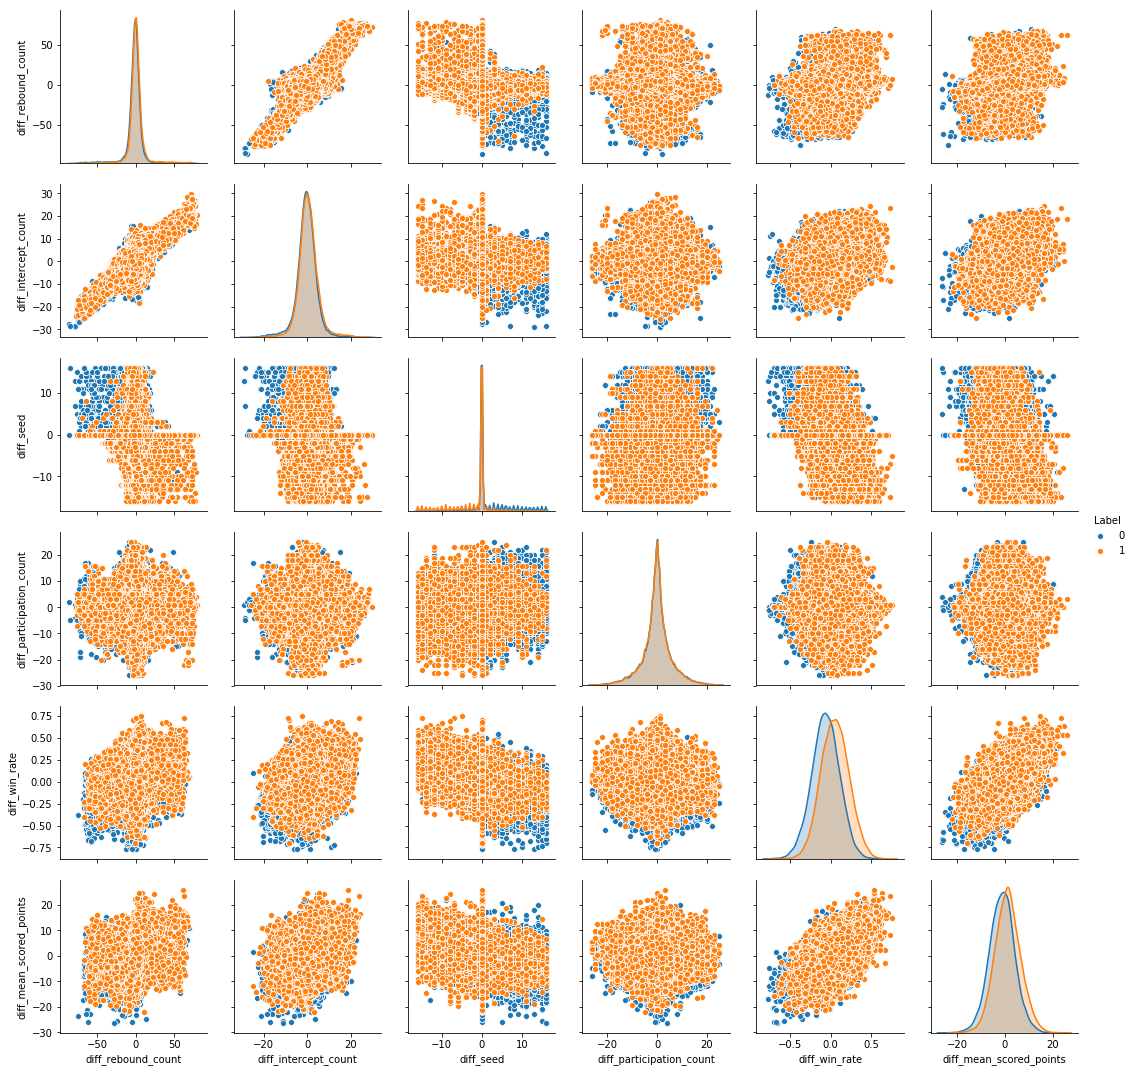

In [50]:


vars_to_plot_1 = ["diff_rebound_count", "diff_intercept_count",  "diff_seed", 
                  "diff_participation_count", "diff_win_rate", "diff_mean_scored_points"]

vars_to_plot_2 = ["diff_rebound_count", "diff_3_points_rate",  "diff_seed", "diff_free_throw_count", 
               "diff_participation_count", "diff_win_rate", "diff_mean_conceded_points"]
vars_to_plot_3 = ['mean_diff_score', 'diff_n_wins']
sns.pairplot(df_diff, 
         hue="Label",
         vars=vars_to_plot_1)

Comme attendu, les clusters gagné et perdus ne se différencient pas trop à part pour quelques variable (win_rate, seed et le nombre de victoire contre l'équipe adverse dans les saisons précédentes)

In [51]:
df_diff

Season  Team1  Team2  Label  Type  diff_rebound_count  \
0        2004   1266   1385      1     0           -2.370548   
1        2004   1193   1385      1     0           -2.835549   
2        2004   1220   1385      1     0            7.084478   
3        2004   1181   1385      1     0           -4.294643   
4        2004   1383   1385      0     0           -8.147665   
5        2004   1210   1385      1     0            1.941621   
6        2004   1335   1385      1     0          -13.326777   
7        2004   1221   1385      0     0           -6.149808   
8        2004   1310   1385      0     0           -2.634710   
9        2004   1371   1385      1     0           -4.021965   
10       2004   1274   1385      1     0           -1.822321   
11       2004   1207   1385      1     0            3.403526   
12       2004   1353   1385      1     0           -2.796474   
13       2004   1338   1385      1     0           -5.879808   
14       2004   1130   1385      1     0           -3.710616   
15       2004   1207   1385      0     0            3.403526   
16       2004   1163   1385      1     0            6.991931   
17       2004   1344   1385      1     0           -6.182692   
18       2004   1130   1385      1     0           -3.710616   
19       2004   1323   1385      1     0           -0.979808   
20       2004   1272   1448      0     0           -0.238551   
21       2004   1189   1448      0     0          -12.106667   
22       2004   1231   1448      0     0           -9.219121   
23       2004   1350   1448      0     0          -12.965641   
24       2004   1374   1448      0     0           -6.035324   
25       2004   1314   1448      0     0           -9.963529   
26       2004   1299   1448      0     0          -13.033333   
27       2004   1307   1448      0     0          -15.562222   
28       2004   1135   1448      0     0          -13.785633   
29       2004   1155   1448      0     0           -8.319487   
...       ...    ...    ...    ...   ...                 ...   
83909    2019   1142   1169      0     0           -2.001071   
83910    2019   1168   1169      1     0           -0.096834   
83911    2019   1142   1169      0     0           -2.001071   
83912    2019   1168   1169      1     0           -0.096834   
83913    2019   1123   1132      0     0            0.879994   
83914    2019   1103   1132      0     0            0.100316   
83915    2019   1103   1132      1     0            0.100316   
83916    2019   1123   1132      0     0            0.879994   
83917    2019   1144   1149      1     0           -5.755095   
83918    2019   1106   1108      1     0            6.483208   
83919    2019   1105   1108      1     0            4.249292   
83920    2019   1106   1108      0     0            6.483208   
83921    2019   1105   1108      0     0            4.249292   
83922    2019   1111   1114      1     0            4.634609   
83923    2019   1122   1125      0     0            1.478491   
83924    2019   1122   1125      0     0            1.478491   
83925    2019   1170   1186      0     0           -1.916995   
83926    2019   1170   1186      1     0           -1.916995   
83927    2019   1123   1138      0     0           -3.275664   
83928    2019   1132   1138      1     0           -4.155657   
83929    2019   1103   1138      0     0           -4.055341   
83930    2019   1103   1138      0     0           -4.055341   
83931    2019   1132   1138      0     0           -4.155657   
83932    2019   1103   1138      0     0           -4.055341   
83933    2019   1132   1138      0     0           -4.155657   
83934    2019   1113   1138      0     1           -6.524527   
83935    2019   1112   1113      0     0            4.146748   
83936    2019   1112   1113      0     0            4.146748   
83937    2019   1104   1116      0     0            0.027013   
83938    2018   1116   1139      0     1            1.141136   

       diff_intercept_count  diff_3_po

In [52]:
df_tmp = df_match_detailed[["Season", "WTeamID", "LTeamID", "Label"]]
mets = df_offset.columns[df_offset.columns != "Season"]
mets = mets[mets != "TeamID"]

df_metrics_1 = df_offset.rename(columns={metric:"W{}".format(metric) for metric in mets})
df_metrics_2 = df_offset.rename(columns={metric:"L{}".format(metric) for metric in mets})

df_metrics_1 = df_metrics_1.rename(columns={"TeamID":"WTeamID"})
df_metrics_2 = df_metrics_2.rename(columns={"TeamID":"LTeamID"})

df_tmp = pd.merge(left=df_tmp, right=df_metrics_1, how='left', on=['Season', 'WTeamID'])
df_matches_bis = pd.merge(left=df_tmp, right=df_metrics_2, on=['Season', 'LTeamID'])

In [53]:
df_matches_bis

Season  WTeamID  LTeamID  Label  Wrebound_count  Wintercept_count  \
0        2004     1266     1385      1       73.259259         17.629630   
1        2004     1193     1385      1       72.794258         25.282297   
2        2004     1220     1385      1       82.714286         17.708333   
3        2004     1181     1385      1       71.335165         25.153846   
4        2004     1210     1385      1       77.571429         26.857143   
5        2004     1335     1385      1       62.303030         17.863636   
6        2004     1393     1385      0       82.366667         30.166667   
7        2004     1371     1385      1       71.607843         20.686275   
8        2004     1274     1385      1       73.807487         28.743316   
9        2004     1437     1385      0       76.800000         21.800000   
10       2004     1207     1385      1       79.033333         31.385714   
11       2004     1353     1385      1       72.833333         29.291667   
12       2004     1452     1385      0       60.438095         20.161905   
13       2004     1338     1385      1       69.750000         23.664286   
14       2004     1130     1385      1       71.919192         19.550505   
15       2004     1452     1385      0       60.438095         20.161905   
16       2004     1439     1385      0       74.883838         23.494949   
17       2004     1163     1385      1       82.621739         25.617391   
18       2004     1344     1385      1       69.447115         28.451923   
19       2004     1130     1385      1       71.919192         19.550505   
20       2004     1323     1385      1       74.650000         23.866667   
21       2004     1448     1272      0       79.673333         22.753333   
22       2004     1228     1272      1       70.314286         19.560000   
23       2004     1379     1272      0       75.966346         19.735577   
24       2004     1177     1272      1       73.291667         15.375000   
25       2004     1257     1272      1       74.308571         23.280000   
26       2004     1153     1272      1       70.318627         18.843137   
27       2004     1387     1272      0       60.177885         17.182692   
28       2004     1329     1272      0       71.823810         27.338095   
29       2004     1338     1104      0       69.750000         23.664286   
...       ...      ...      ...    ...             ...               ...   
83909    2019     1207     1385      1       69.332248         20.940971   
83910    2019     1181     1385      1       71.569937         20.392037   
83911    2019     1344     1385      1       73.382588         21.414448   
83912    2019     1344     1385      1       73.382588         21.414448   
83913    2019     1462     1385      0       72.775219         17.692033   
83914    2019     1177     1385      1       68.086896         22.084099   
83915    2019     1462     1385      0       72.775219         17.692033   
83916    2019     1266     1385      1       67.861070         20.778258   
83917    2019     1113     1385      1       67.609642         19.229733   
83918    2019     1307     1305      0       70.964022         19.027848   
83919    2019     1361     1305      0       73.226208         20.381018   
83920    2019     1429     1305      0       69.076376         15.358804   
83921    2019     1361     1305      0       73.226208         20.381018   
83922    2019     1196     1305      1       71.120883         19.966699   
83923    2019     1396     1222      0       70.241872         19.884601   
83924    2019     1416     1222      0       72.091621         19.944610   
83925    2019     1153     1222      1       72.920332         22.858155   
83926    2019     1246     1222      0       74.929269         23.310329   
83927    2019     1181     1438      1       71.569937         20.392037   
83928    2019     1181     1438      1       71.569937         20.392037   
83929    2019     1199     1438      1       71.481166 

In [54]:
season_winners = df_match_detailed.loc[df_match_detailed.DayNum == 154][["WTeamID", "Season"]]

In [55]:
season_winners

WTeamID  Season
63       1393    2003
127      1163    2004
191      1314    2005
255      1196    2006
319      1196    2007
383      1242    2008
447      1314    2009
511      1181    2010
578      1163    2011
645      1246    2012
712      1257    2013
779      1163    2014
846      1181    2015
913      1437    2016
980      1314    2017
1047     1437    2018
1114     1438    2019

In [56]:
season_winners = df_match_detailed.loc[df_match_detailed.DayNum == 154][["WTeamID", "Season"]]
winners_carac = pd.DataFrame(columns = df_offset.columns)
seasons = season_winners["Season"].values
for i, winner in enumerate(season_winners.WTeamID.values):
    season = seasons[i]
    carac = df_offset.loc[(df_offset.TeamID == winner) & (df_offset["Season"] == season)]
    winners_carac = pd.concat([winners_carac, carac])

season_losers = df_match_detailed.loc[df_match_detailed.DayNum == 132][["LTeamID", "Season"]]
losers_carac = pd.DataFrame(columns = df_offset.columns)
seasons = season_losers["Season"].values
for i, loser in enumerate(season_losers.LTeamID.values):
    season = seasons[i]
    carac = df_offset.loc[(df_offset.TeamID == loser) & (df_offset["Season"] == season)]
    losers_carac = pd.concat([losers_carac, carac])

In [57]:
losers_carac

TeamID  rebound_count  intercept_count  3_points_rate  free_throw_count  \
95     1196      66.785000        20.725000       0.372249         24.380000   
9      1110      66.178571        16.151786       0.374904         22.366071   
80     1181      71.335165        25.153846       0.338082         34.912088   
299    1400      82.120879        18.631868       0.373059         35.846154   
127    1228      70.314286        19.560000       0.344774         26.222857   
372    1106      70.757532        21.704006       0.340296         25.340705   
476    1210      75.107143        26.135714       0.349373         29.478571   
512    1246      70.914583        21.611690       0.307615         26.224769   
724    1458      62.992262        17.728452       0.335650         27.132024   
669    1403      67.731829        21.747804       0.313647         27.787879   
588    1322      77.445203        25.012955       0.310385         31.372724   
763    1130      70.993620        20.537391       0.326855         32.658081   
1009   1376      67.774754        24.761879       0.314201         24.617659   
959    1326      66.761473        16.604190       0.346760         27.115640   
1033   1400      79.789711        19.257026       0.364410         31.404077   
991    1358      73.405026        23.567725       0.344276         30.442593   
1116   1116      70.879032        24.597189       0.332308         27.981424   
1400   1400      79.116093        20.348722       0.363169         30.649486   
1301   1301      64.301218        21.315704       0.347832         29.420027   
1458   1458      66.179625        16.408334       0.346972         27.144740   
1322   1322      74.709201        23.833257       0.333728         31.297722   
1483   1116      70.688940        24.787275       0.332285         28.151806   
1767   1400      79.052874        21.378978       0.365525         31.603589   
1522   1155      72.701409        26.681714       0.330592         25.981193   
1689   1322      73.624028        24.557439       0.339512         32.704011   
1595   1228      69.993437        18.087902       0.330368         22.329812   
2068   1334      66.841618        15.870786       0.357709         27.796672   
1933   1199      66.991256        23.601329       0.362614         28.310503   
2131   1397      69.188490        21.574326       0.366195         29.177489   
2060   1326      66.929895        19.088471       0.343189         25.305550   
...     ...            ...              ...            ...               ...   
4002   1433      67.407379        23.246621       0.353550         27.106620   
3778   1209      67.782559        22.025609       0.354768         25.028004   
3750   1181      71.018199        23.179106       0.344489         32.203522   
4140   1204      66.590023        21.238556       0.356216         25.442215   
4052   1116      69.848670        25.241247       0.336049         30.475103   
4099   1163      78.363299        26.703467       0.325679         31.964595   
4109   1173      71.130885        16.717921       0.356317         26.550421   
4213   1277      72.811485        19.906510       0.342832         26.983195   
4722   1419      66.808104        17.422953       0.353627         27.269190   
4575   1272      72.229331        27.272574       0.328851         28.386821   
4704   1401      70.273517        17.583315       0.340430         28.189643   
4648   1345      69.189401        20.981958       0.333327         27.127024   
4736   1433      68.586004        24.735578       0.346789         27.760831   
4786   1116      70.367390        24.715801       0.344518         31.059031   
5128   1458      65.926555        16.288939       0.341252         25.460810   
5133   1463      69.491355        19.642116       0.325545         30.906096   
5103   1433      69.564359        25.026169       0.342789         27.422505   
4823   1153      73.412660        21.498406       0.316965         24.402704   
5072 

In [58]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

df_winner = df_matches_bis[["Wrebound_count", "Wintercept_count", "W3_points_rate", "Wfree_throw_count", "Wparticipation_count"]]
df_loser = df_matches_bis[["Lrebound_count", "Lintercept_count", "L3_points_rate", "Lfree_throw_count", "Lparticipation_count"]]

df_norm_winner = df_winner / df_winner.max()
df_norm_loser = df_loser / df_loser.max()

df_tournoy_winners = winners_carac[["rebound_count", "intercept_count", "3_points_rate", "free_throw_count", "participation_count"]]
df_tournoy_winners = df_tournoy_winners / df_tournoy_winners.max()

df_tournoy_losers = losers_carac[["rebound_count", "intercept_count", "3_points_rate", "free_throw_count", "participation_count"]]
df_tournoy_losers = df_tournoy_losers / df_tournoy_losers.max()
categories= ["Rebounds", "Interceptions", "3 points", "Free throw", "Participation"]

fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "scatterpolar"}, {"type": "scatterpolar"}]],
                    subplot_titles = ('Random match', 'Tourney characteristics'))

match = random.randint(0, df_winner.shape[0])

fig.add_trace(go.Scatterpolar(r=df_norm_winner.iloc[match].values,
                              theta=categories,
                              fill='toself',
                              name='Winner team',
                             cliponaxis=True), 
              row=1, col=1)

fig.add_trace(go.Scatterpolar(r=df_norm_loser.iloc[match].values,
                              theta=categories,
                              fill='toself',
                              name='Loser team',
                             cliponaxis=True),
              row=1, col=1)

fig.add_trace(go.Scatterpolar(r=df_tournoy_winners.mean().values,
                              theta=categories,
                              fill='toself',
                              name='Tourney winners',
                             cliponaxis=True,
                             line_color='darkviolet'),
             row=1, col=2)

fig.add_trace(go.Scatterpolar(r=df_tournoy_losers.mean().values,
                              theta=categories,
                              fill='toself',
                              name='Tourney losers',
                             cliponaxis=True,
                             line_color='lightgreen'),
             row=1, col=2)
fig.update_layout(
    title={'text': "Comparison of two teams characteristics",
           'y':0.95,
           'x':0.44,
           'xanchor': 'center',
           'yanchor': 'top'},
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    )
)


fig.show()

* A gauche : les caractéristiques de deux équipes pour un match aléatoire
* A droite : les caractéristiques moyenne des gagnant du tournoi pour chaque saison et les caractéristiques des perdants au premier tour du tournoi. Onvoit que la différence n'est pas énorme sur nos paramètres, surtout pour le pourcentage des tirs à 3points

In [59]:
df_matches

Season  Team1  Team2  Label  Type  Team1_rebound_count  \
0        2004   1266   1385      1     0            73.259259   
1        2004   1193   1385      1     0            72.794258   
2        2004   1220   1385      1     0            82.714286   
3        2004   1181   1385      1     0            71.335165   
4        2004   1383   1385      0     0            67.482143   
5        2004   1210   1385      1     0            77.571429   
6        2004   1335   1385      1     0            62.303030   
7        2004   1221   1385      0     0            69.480000   
8        2004   1310   1385      0     0            72.995098   
9        2004   1371   1385      1     0            71.607843   
10       2004   1274   1385      1     0            73.807487   
11       2004   1207   1385      1     0            79.033333   
12       2004   1353   1385      1     0            72.833333   
13       2004   1338   1385      1     0            69.750000   
14       2004   1130   1385      1     0            71.919192   
15       2004   1207   1385      0     0            79.033333   
16       2004   1163   1385      1     0            82.621739   
17       2004   1344   1385      1     0            69.447115   
18       2004   1130   1385      1     0            71.919192   
19       2004   1323   1385      1     0            74.650000   
20       2004   1272   1448      0     0            79.434783   
21       2004   1189   1448      0     0            67.566667   
22       2004   1231   1448      0     0            70.454212   
23       2004   1350   1448      0     0            66.707692   
24       2004   1374   1448      0     0            73.638009   
25       2004   1314   1448      0     0            69.709804   
26       2004   1299   1448      0     0            66.640000   
27       2004   1307   1448      0     0            64.111111   
28       2004   1135   1448      0     0            65.887701   
29       2004   1155   1448      0     0            71.353846   
...       ...    ...    ...    ...   ...                  ...   
83909    2019   1142   1169      0     0            67.200279   
83910    2019   1168   1169      1     0            69.104516   
83911    2019   1142   1169      0     0            67.200279   
83912    2019   1168   1169      1     0            69.104516   
83913    2019   1123   1132      0     0            70.858506   
83914    2019   1103   1132      0     0            70.078829   
83915    2019   1103   1132      1     0            70.078829   
83916    2019   1123   1132      0     0            70.858506   
83917    2019   1144   1149      1     0            65.193111   
83918    2019   1106   1108      1     0            73.977008   
83919    2019   1105   1108      1     0            71.743092   
83920    2019   1106   1108      0     0            73.977008   
83921    2019   1105   1108      0     0            71.743092   
83922    2019   1111   1114      1     0            72.037578   
83923    2019   1122   1125      0     0            68.013209   
83924    2019   1122   1125      0     0            68.013209   
83925    2019   1170   1186      0     0            66.372605   
83926    2019   1170   1186      1     0            66.372605   
83927    2019   1123   1138      0     0            70.858506   
83928    2019   1132   1138      1     0            69.978512   
83929    2019   1103   1138      0     0            70.078829   
83930    2019   1103   1138      0     0            70.078829   
83931    2019   1132   1138      0     0            69.978512   
83932    2019   1103   1138      0     0            70.078829   
83933    2019   1132   1138      0     0            69.978512   
83934    2019   1113   1138      0     1            67.609642   
83935    2019   1112   1113      0     0            71.756390   
83936    2019   1112   1113      0     0            71.756390   
83937    2019   1104   1116      0     0            69.225377   
83938    2018   1116   1139      0     1  

## Modelisation

On implémente ici trois model:
* Un réseau de neurone 
* Une régression ogistique
* Un XGBoost classifieur

In [60]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -np.log(p)
    return -np.log(1 - p)

print(f'Confident Wrong Prediction: \t\t {logloss(1, 0.01):0.4f}')
print(f'Confident Correct Prediction: \t\t {logloss(0, 0.01):0.4f}')
print(f'Non-Confident Wrong Prediction: \t {logloss(1, 0.49):0.4f}')
print(f'Non-Confident Correct Prediction: \t {logloss(0, 0.49):0.4f}')

Confident Wrong Prediction: 		 4.6052
Confident Correct Prediction: 		 0.0101
Non-Confident Wrong Prediction: 	 0.7133
Non-Confident Correct Prediction: 	 0.6733


### Neural network classifier

In [61]:
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler

In [62]:
# Pour l'entrainement on utilise tous les matchs de la saison (MarchMadness et Regular)
df_train = df_diff.loc[(df_diff.Season <2015)].dropna()
# Pour le test on ne regarde que les résultats du tournoi MarchMadness
df_test = df_diff.loc[(df_diff.Season >=2015) & (df_diff.Type == 1)].dropna()

X_train = df_train.drop(columns=['Season', "Team1", "Team2", "Label", "Type"]).values
y_train = df_train["Label"].values
y_train = y_train.reshape(y_train.shape[0], 1)

X_test = df_test.drop(columns=['Season', "Team1", "Team2", "Label", "Type"]).values
y_test = df_test["Label"].values

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [63]:
X_train.shape

(55973, 9)

In [64]:
module = nn.Sequential(
    nn.Linear(X_train.shape[1], 24),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(24, 84),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(84, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 84),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(84, 2),
    nn.Softmax(),
)

In [65]:
net = NeuralNetClassifier(
    module,
    max_epochs=50,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer=optim.SGD)

In [66]:
net.fit(torch.Tensor(X_train), torch.Tensor(y_train.ravel()).long())

/home/kostia/.virtualenvs/machine-learning/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6932       0.5636        0.6909  3.0308
      2        0.6906       0.5596        0.6879  3.1078
      3        0.6877       0.6253        0.6825  3.1174
      4        0.6824       0.6516        0.6720  3.0721
      5        0.6709       0.6585        0.6504  3.1308
      6        0.6523       0.6623        0.6232  2.8866
      7        0.6383       0.6644        0.6107  3.1374
      8        0.6305       0.6674        0.6051  3.1303
      9        0.6269       0.6709        0.6019  3.0553
     10        0.6241       0.6760        0.5993  3.2198
     11        0.6219       0.6782        0.5970  2.9578
     12        0.6190       0.6784        0.5952  3.1337
     13        0.6160       0.6791        0.5934  3.2200
     14        0.6151       0.6789        0.5923  3.1614
     15        0.6165       0.6785        0.5913  3.2234
     16        0.6135       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=9, out_features=24, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=24, out_features=84, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=84, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=84, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=84, out_features=2, bias=True)
    (16): Softmax(dim=None)
  ),
)

In [69]:
preds_proba = net.predict_proba(torch.Tensor(X_test))
preds = net.predict(torch.Tensor(X_test))

In [70]:
np.sum(preds == y_test)/len(y_test)

0.7104477611940299

In [71]:
print("Accuracy =", np.sum(preds == y_test)/len(y_test))
print("Confusion matrix :\n", confusion_matrix(y_test, preds))
print("Classification report :\n", classification_report(y_test, preds))

lloss = 0
preds_team1_wins = preds_proba[:,1]
for i,proba in enumerate(preds_team1_wins):
    lloss += logloss(y_test[i], proba)
lloss = lloss/len(y_test)
print("#" * 20)
print("\n\n")
print("Loss on test dataset = {}".format(lloss))

Accuracy = 0.7104477611940299
Confusion matrix :
 [[121  61]
 [ 36 117]]
Classification report :
               precision    recall  f1-score   support

           0       0.77      0.66      0.71       182
           1       0.66      0.76      0.71       153

   micro avg       0.71      0.71      0.71       335
   macro avg       0.71      0.71      0.71       335
weighted avg       0.72      0.71      0.71       335

####################



Loss on test dataset = 0.5530039435981261


### Logistic Regression

In [72]:
params = {'C':np.logspace(start = -5, stop = 3, num = 9)} 

In [73]:
logreg = LogisticRegression(solver="lbfgs")
clf = GridSearchCV(logreg, params, scoring = 'neg_log_loss', refit = True, cv=5, iid=False)
clf.fit(X_train, y_train.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [74]:
preds_proba = clf.predict_proba(X_test)
preds = clf.predict(X_test)
print("Accuracy =", np.sum(preds == y_test)/len(y_test))
print("Confusion matrix :\n", confusion_matrix(y_test, preds))
print("Classification report :\n", classification_report(y_test, preds))

lloss = 0
preds_team1_wins = preds_proba[:,1]
for i,proba in enumerate(preds_team1_wins):
    lloss += logloss(y_test[i], proba)
lloss = lloss/len(y_test)
print("#" * 20)
print("\n\n")
print("Score on test dataset = {}".format(lloss))

Accuracy = 0.7283582089552239
Confusion matrix :
 [[127  55]
 [ 36 117]]
Classification report :
               precision    recall  f1-score   support

           0       0.78      0.70      0.74       182
           1       0.68      0.76      0.72       153

   micro avg       0.73      0.73      0.73       335
   macro avg       0.73      0.73      0.73       335
weighted avg       0.73      0.73      0.73       335

####################



Score on test dataset = 0.5574296450073766


### XGBoost

In [75]:
xgbc = XGBClassifier(objective = "binary:logistic", 
                     eval_set = [(X_train, y_train.ravel()), (X_test, y_test.ravel())],
                     eval_metric="logloss", verbose=True)

In [76]:
xgbc.fit(X_train, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='logloss',
       eval_set=[(array([[-0.21124, -2.34006, ...,  0.01704, -0.01481],
       [-0.25274, -0.6648 , ...,  0.2353 , -0.01481],
       ...,
       [ 0.17406, -0.83017, ...,  2.85448, -0.01481],
       [ 0.15922, -0.13836, ..., -0.41949, -0.01481]]), array([1, 1, ..., 0, 1])), (array([[-0.2217 , -0.48605, ......21815,  0.65223],
       [ 0.15237,  1.93011, ..., -0.32118, -0.43482]]), array([0, 0, ..., 0, 0]))],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose=True)

In [77]:
preds_proba = xgbc.predict_proba(X_test)
preds = xgbc.predict(X_test)
print("Accuracy =", np.sum(preds == y_test)/len(y_test))
print("Confusion matrix :\n", confusion_matrix(y_test, preds))
print("Classification report :\n", classification_report(y_test, preds))

lloss = 0
preds_team1_wins = preds_proba[:,1]
for i,proba in enumerate(preds_team1_wins):
    lloss += logloss(y_test[i], proba)
lloss = lloss/len(y_test)
print("#" * 20)
print("\n\n")
print("Score on test dataset = {}".format(lloss))

Accuracy = 0.7194029850746269
Confusion matrix :
 [[128  54]
 [ 40 113]]
Classification report :
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       182
           1       0.68      0.74      0.71       153

   micro avg       0.72      0.72      0.72       335
   macro avg       0.72      0.72      0.72       335
weighted avg       0.72      0.72      0.72       335

####################



Score on test dataset = 0.5608928296904561


In [78]:
importances = pd.DataFrame({
    'Feature': df_train.drop(columns=['Season', "Team1", "Team2", "Label", "Type"]).columns,
    'Importance': xgbc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

Importance
Feature                              
diff_seed                    0.515067
diff_win_rate                0.328589
diff_mean_conceded_points    0.042558
diff_mean_scored_points      0.034033
diff_rebound_count           0.023038
diff_intercept_count         0.017344
diff_3_points_rate           0.015306
diff_free_throw_count        0.013145
diff_participation_count     0.010919

### keep only most important feature (seed, win rate)

In [79]:
df_train = df_diff.loc[(df_diff.Season <2015)].dropna()
df_test = df_diff.loc[(df_diff.Season >=2015) & (df_diff.Type == 1)].dropna()

X_train = df_train[["diff_seed", "diff_win_rate"]].values
y_train = df_train["Label"].values
y_train = y_train.reshape(y_train.shape[0], 1)

X_test = df_test[["diff_seed", "diff_win_rate"]].values
y_test = df_test["Label"].values

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [80]:
params = {'C':np.logspace(start = -5, stop = 3, num = 9)}
logreg = LogisticRegression(solver="lbfgs")
clf = GridSearchCV(logreg, params, scoring = 'neg_log_loss', refit = True, cv=5, iid=False)
clf.fit(X_train, y_train.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [81]:
preds_proba = clf.predict_proba(X_test)
preds = clf.predict(X_test)
print("Accuracy =", np.sum(preds == y_test)/len(y_test))
print("Confusion matrix :\n", confusion_matrix(y_test, preds))
print("Classification report :\n", classification_report(y_test, preds))

lloss = 0
preds_team1_wins = preds_proba[:,1]
for i,proba in enumerate(preds_team1_wins):
    lloss += logloss(y_test[i], proba)
lloss = lloss/len(y_test)
print("Score on test dataset = {}".format(lloss))

Accuracy = 0.7194029850746269
Confusion matrix :
 [[126  56]
 [ 38 115]]
Classification report :
               precision    recall  f1-score   support

           0       0.77      0.69      0.73       182
           1       0.67      0.75      0.71       153

   micro avg       0.72      0.72      0.72       335
   macro avg       0.72      0.72      0.72       335
weighted avg       0.72      0.72      0.72       335

Score on test dataset = 0.5544589592747197
